In [ ]:
# This code replicates the algorithm from Human-Level Control Through Deep Reinforcement Learning (2015 Mnih et al) https://daiwk.github.io/assets/dqn.pdf
!pip install gym

In [ ]:
import random
import gym
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt

In [ ]:
# Instantiate the neural network
class DeepQNetworkCartpole(nn.Module):
  def __init__(self, env):
        super().__init__()
        self.network = nn.Sequential(
            nn.Linear(np.array(env.observation_space.shape).prod(), 120),
            nn.ReLU(),
            nn.Linear(120, 84),
            nn.ReLU(),
            nn.Linear(84, env.action_space.n),
        )
        print(self.network)

  def forward(self, x):
      return self.network(x)

In [ ]:
# Instantiate the replay buffer
class ReplayBuffer:

  def __init__(self, max_frames):
    self.max_frames = max_frames
    self.buffer = []

  def add(self, frame):
    self.buffer.append(frame)
    if len(self.buffer) > self.max_frames:
      del self.buffer[0:len(self.buffer)-self.max_frames]

  def sample(self, num_samples):
    sample_nums = set() # Ensure we don't pick the same frame twice.
    while len(sample_nums) < num_samples:
      sample_nums.add(random.randrange(len(self.buffer)))
    experiences = [self.buffer[i] for i in sample_nums]
    return {"obs": torch.stack([torch.as_tensor(experience["obs"], dtype=torch.float32) for experience in experiences], 0),
            "next_obs": torch.stack([torch.as_tensor(experience["next_obs"], dtype=torch.float32) for experience in experiences], 0),
            "actions": torch.stack([torch.as_tensor(experience["action"], dtype=torch.int64) for experience in experiences], 0),
            "rewards": torch.stack([torch.as_tensor(experience["reward"], dtype=torch.float32) for experience in experiences], 0),
            "dones": torch.stack([torch.as_tensor(experience["done"], dtype=torch.float32) for experience in experiences], 0)}

In [ ]:
# Helper functions
def plot_results(steps, rewards, total_timesteps):
  plt.plot([item for item in get_rolling_average(steps, 10)], 
          [item for item in get_rolling_average(rewards, 10)])
  max_x = [0, total_timesteps]
  max_y = [500, 500] # Cartpole max.
  plt.plot(max_x, max_y, color='r', ls=':')
  plt.xlabel(f"Number of Steps (Avg. 10)")
  plt.ylabel(f"Current Return (Avg. 10)")
  plt.show()

def get_rolling_average(items, num):
    rolling = []
    for i in range(len(items)-num):
        rolling.append(sum(items[i:i+num])/num)
    return rolling

def calculate_epsilon(step, epsilon_start, epsilon_finish, 
                      total_timesteps, exploration_fraction):
  finish_step = total_timesteps * exploration_fraction
  if step > finish_step:
    return epsilon_finish
  epsilon_range = epsilon_start - epsilon_finish
  return epsilon_finish + (((finish_step - step) / finish_step) * epsilon_range)

In [ ]:
def train(env, total_timesteps, batch_size, buffer_size, train_frequency, seed,
          target_network_update_frequency,  gamma, learning_rate, epsilon_start, 
          epsilon_finish, exploration_fraction, learn_start_size, noop_size):
  
  env = gym.make(env)
  device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

  random.seed(seed)
  np.random.seed(seed)
  torch.manual_seed(seed)
  torch.backends.cudnn.deterministic = True if seed > 0 else False

  # Initialise replay memory D to capacity N
  buffer = ReplayBuffer(buffer_size)

  # Initialize action-value function Q and target network.
  q_network = DeepQNetworkCartpole(env).to(device)
  target_network = DeepQNetworkCartpole(env).to(device)
  target_network.load_state_dict(q_network.state_dict())
  optimiser = torch.optim.Adam(q_network.parameters(), learning_rate)

  obs = env.reset()
  episode_end_steps = []
  episode_rewards = []
  last_episode_end_step = 0

  for step in range(total_timesteps):

    # Select random action with p(epsilon), else argmax(q).
    epsilon = calculate_epsilon(step, epsilon_start, epsilon_finish, 
                                total_timesteps, exploration_fraction)
    
    # Add noop code later - probably will kill Cartpole.
    if random.random() < epsilon:
      action = env.action_space.sample()
    else:
      logits = q_network(torch.Tensor(obs).to(device))
      action = torch.argmax(logits, dim=0).cpu().numpy().tolist()

    next_obs, reward, done, info = env.step(action)

    next_obs_copy = next_obs.copy()

    # Store transition in D.
    buffer.add({"obs": obs, "next_obs": next_obs_copy, "action": [action], 
                "reward": [reward], "done": [1. if done else 0.], "info": info})
    
    if done: # If episode is done.
      print(f"global_step={step}, episodic_return={step-last_episode_end_step}")
      episode_end_steps.append(step)
      episode_rewards.append(step-last_episode_end_step)
      last_episode_end_step = step
      obs = env.reset()
      continue

    obs = next_obs

    if step > learn_start_size and step % train_frequency == 0:

      # Sample replay experiences.
      experiences = buffer.sample(batch_size)

      with torch.no_grad(): # We want to sample the Q-network here, but not update it yet.

        # Changing target_network to q_network here implements DDQN, which is superior.
        target_max, _ = q_network(experiences["next_obs"]).max(dim=1) # The _ removes the indices we don't want, leaving only the values.
        td_target = experiences["rewards"].flatten() + gamma * target_max * (1 - experiences["dones"].flatten()) # If done, sets second term to 0, since we just want rewards.

      old_val = q_network(experiences["obs"]).gather(1, experiences["actions"]).squeeze() # Collect tensor of predicted rewards associated with the actions taken.

      # Calculate loss
      loss = F.mse_loss(td_target, old_val)

      # Gradient descent
      optimiser.zero_grad()
      loss.backward()
      optimiser.step()

    # Update target network.
    if step % target_network_update_frequency == 0:
      target_network.load_state_dict(q_network.state_dict())

  env.close()
  plot_results(episode_end_steps, episode_rewards, total_timesteps)

train(env='CartPole-v1', total_timesteps=100000, batch_size=32, buffer_size=100000, 
      train_frequency=4, seed=1, target_network_update_frequency=500, 
      gamma=0.99, learning_rate=2.5e-4, epsilon_start=1, epsilon_finish=0.01, 
      exploration_fraction=0.1, learn_start_size=8000, noop_size=30)

Results compared to CleanRL, using the same seed. CleanRL is on the top, this code on the bottom.

DQN:

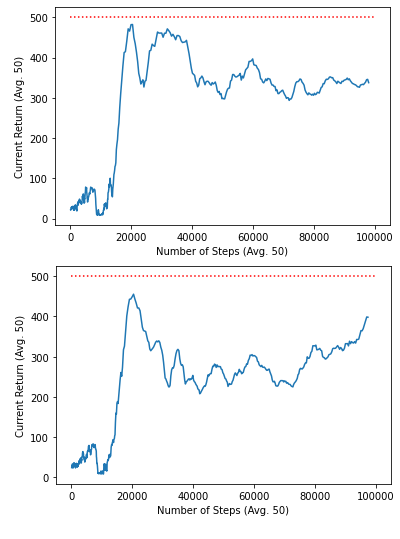

DDQN:

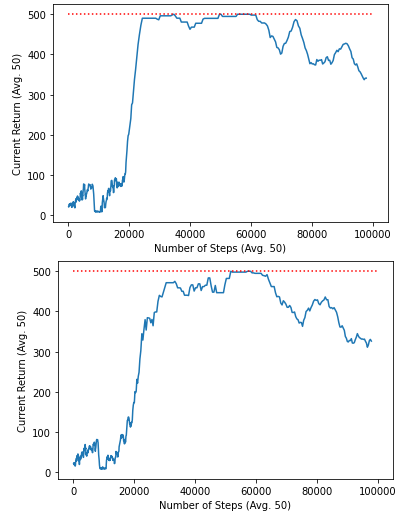